In [1]:
#Histopathological Cancer Detection Project

# CNN Model 3: Transfer learning, Data augmentation, and <50% sample of Data

## Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, datasets

2025-07-19 12:25:39.887350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752927940.084207      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752927940.141036      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## View Data, Distributions, and Images with labels

In [3]:
train = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [4]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
train.isnull().sum().T

id       0
label    0
dtype: int64

In [6]:
(train.label.value_counts()/len(train.label)).to_frame().T

label,0,1
count,0.594969,0.405031


In [7]:
train['filenames'] = train['id']+'.tif'

In [8]:
train.head()

,id,label,filenames
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


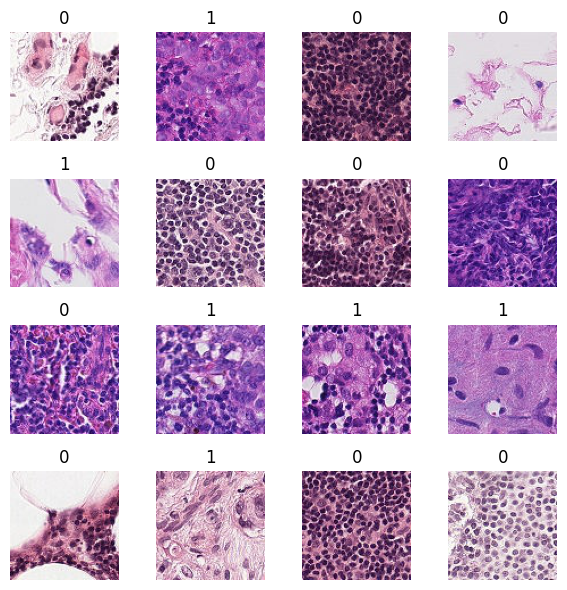

In [9]:
train_images_path = '/kaggle/input/histopathologic-cancer-detection/train'
sample = train.sample(n=16).reset_index()

plt.figure(figsize = (6,6))

for i in range(len(sample)):
    img = mpimg.imread(f'{train_images_path}/{sample.filenames[i]}')
    #label = sample.label
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.title(sample.label[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Sample the Data to make training more efficient

In [10]:
SS = 50000
RS = 10

positives = train[train['label']==1].sample(SS, random_state = RS)
negatives = train[train['label']==0].sample(SS, random_state = SS)

new_train = pd.concat([positives,negatives], axis = 0).reset_index(drop = True)
new_train = shuffle(new_train)

In [11]:
new_train.head()

,id,label,filenames
31850,d02904b168ed8b9dec314d78fcb51feeee21f2e5,1,d02904b168ed8b9dec314d78fcb51feeee21f2e5.tif
43325,60ce885e0d99825aab7843c26770da43ed1fadb4,1,60ce885e0d99825aab7843c26770da43ed1fadb4.tif
3661,2ce9b12fc7b2b8c99684ffc092baea9a9c05005f,1,2ce9b12fc7b2b8c99684ffc092baea9a9c05005f.tif
35426,2aeab4d7e69afe46956669ec2e6955deb9be1bee,1,2aeab4d7e69afe46956669ec2e6955deb9be1bee.tif
1348,49a7796b87e5681529a63f2bdfd83ef8aa480c9e,1,49a7796b87e5681529a63f2bdfd83ef8aa480c9e.tif


In [12]:
(new_train.label.value_counts()/len(new_train)).to_frame().T

label,1,0
count,0.5,0.5


## Train_Test_Split

In [13]:
train_df, val_df = train_test_split(new_train, test_size = .2, random_state = 10, stratify = new_train.label)

print(train_df.shape)
print(val_df.shape)

(80000, 3)
(20000, 3)


## Rescale Images with ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(rescale = 1/255)
val_datagen = ImageDataGenerator(rescale = 1/255)

### Make labels into strings

In [15]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

## Create loaders using data augmentation
* horizontal and vertical flips
* rotation
* height and width shifts
* Images sized 64x64

In [16]:
%%time
batch_size = 96

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_images_path,
    x_col = 'filenames',
    y_col = 'label',
    batch_size = batch_size,
    seed = 10,
    shuffle = True,
    class_mode = 'binary',
    horizontal_flip = True,
    vertical_flip = True,
    height_shift_range = .1,
    width_shift_range = .1,
    rotation_range = 15,
    target_size = (96,96)
)

val_loader = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = train_images_path,
    x_col = 'filenames',
    y_col = 'label',
    batch_size = batch_size,
    seed = 10,
    shuffle = True,
    class_mode = 'binary',
    target_size = (96,96)
)

Found 80000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.
CPU times: user 1.76 s, sys: 3.4 s, total: 5.15 s
Wall time: 6min 43s


In [17]:
TR_STEPS = len(train_loader)
VAL_STEPS = len(val_loader)

print(TR_STEPS)
print(VAL_STEPS)

834
209


## Create a model using the ResNet101 model form keras as the foundation
* Print the Architecture of the model
* very little learning rate will be used to make sure the model doesn't over fit
* More epochs will be used becasue of the efficiency of training compared to the other models

In [18]:
base_model_1 = tf.keras.applications.ResNet101(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)
base_model_1.trainable = True 



cnn_model_2 = models.Sequential([
    base_model_1,
    layers.GlobalAveragePooling2D(),


    Dense(128, activation = 'relu'),
    Dropout(.2),
    Dense(64, activation = 'relu'),
    Dropout(.2),
    Dense(32, activation = 'relu'),
    Dropout(.2),
    Dense(1, activation = 'sigmoid')
])
cnn_model_2.summary()

I0000 00:00:1752928358.453949      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 3, 3, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,930,817 (163.77 MB)

 Trainable params: 42,825,473 (163.37 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate = 1e-7)
cnn_model_2.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['AUC'])

## Run the first training iteration
* very small learning rate

In [20]:
%%time
h1 = cnn_model_2.fit(
    x = train_loader,
    steps_per_epoch = TR_STEPS,
    epochs = 50,
    validation_data = val_loader,
    validation_steps = VAL_STEPS,
    verbose = 1,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1752928472.346404      61 service.cc:148] XLA service 0x7fc1ec002d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752928472.347331      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752928481.903229      61 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752928512.561837      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


834/834 ━━━━━━━━━━━━━━━━━━━━ 985s 1s/step - AUC: 0.4639 - loss: 0.9318 - val_AUC: 0.6104 - val_loss: 0.8336
Epoch 2/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 179s 214ms/step - AUC: 0.5175 - loss: 0.8527 - val_AUC: 0.5874 - val_loss: 0.7579
Epoch 3/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 178s 213ms/step - AUC: 0.5589 - loss: 0.7946 - val_AUC: 0.6368 - val_loss: 0.7113
Epoch 4/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 178s 213ms/step - AUC: 0.5886 - loss: 0.7485 - val_AUC: 0.6738 - val_loss: 0.6815
Epoch 5/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 178s 213ms/step - AUC: 0.6177 - loss: 0.7090 - val_AUC: 0.6973 - val_loss: 0.6648
Epoch 6/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 178s 214ms/step - AUC: 0.6325 - loss: 0.6909 - val_AUC: 0.7200 - val_loss: 0.6563
Epoch 7/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 178s 214ms/step - AUC: 0.6455 - loss: 0.6790 - val_AUC: 0.7424 - val_loss: 0.6490
Epoch 8/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 178s 213ms/step - AUC: 0.6659 - loss: 0.6678 - val_AUC: 0.7630 - val_loss: 0.6420
Epoch 9/50
834/834 ━━━━━━━━━━━━━━━━━━━

## Run the second training iteration
* keep the same learning rate
* stay with 50 epochs

In [21]:
history = h1.history

In [22]:
%%time
opt.learning_rate.assign(1e-7)
h2 = cnn_model_2.fit(
    x = train_loader,
    steps_per_epoch = TR_STEPS,
    epochs = 50,
    validation_data = val_loader,
    validation_steps = VAL_STEPS,
    verbose = 1
)

Epoch 1/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 176s 211ms/step - AUC: 0.9168 - loss: 0.3751 - val_AUC: 0.9397 - val_loss: 0.3232
Epoch 2/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 175s 210ms/step - AUC: 0.9203 - loss: 0.3707 - val_AUC: 0.9408 - val_loss: 0.3191
Epoch 3/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 175s 210ms/step - AUC: 0.9205 - loss: 0.3682 - val_AUC: 0.9419 - val_loss: 0.3161
Epoch 4/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 174s 209ms/step - AUC: 0.9232 - loss: 0.3628 - val_AUC: 0.9426 - val_loss: 0.3138
Epoch 5/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 176s 211ms/step - AUC: 0.9245 - loss: 0.3597 - val_AUC: 0.9436 - val_loss: 0.3100
Epoch 6/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 175s 210ms/step - AUC: 0.9238 - loss: 0.3600 - val_AUC: 0.9444 - val_loss: 0.3077
Epoch 7/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 175s 210ms/step - AUC: 0.9264 - loss: 0.3543 - val_AUC: 0.9453 - val_loss: 0.3049
Epoch 8/50
834/834 ━━━━━━━━━━━━━━━━━━━━ 174s 209ms/step - AUC: 0.9279 - loss: 0.3510 - val_AUC: 0.9460 - val_loss: 0.3025
Epoch 9/50
834/834 ━━━━━

## Display the model's performance
* slowly but steadily increased in performance for both training and validation data
* could keep training to improve performance, but balancing time and computational resources
* Does extremely well using the whole 96x96 image size without taking too long to train

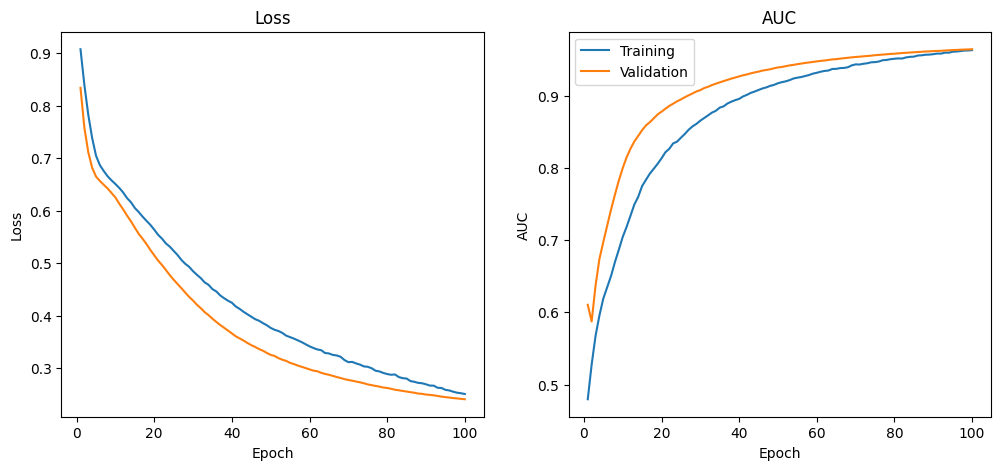

In [23]:
for k in history.keys():
    history[k]+=h2.history[k]

epoch_range = range(1, len(history['loss'])+1)
plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epoch_range, history['AUC'], label = 'Training')
plt.plot(epoch_range, history['val_AUC'], label = 'Validation')
plt.xlabel("Epoch");plt.ylabel("AUC");plt.title("AUC")
plt.legend()
plt.show()

## Save the model

In [24]:
import pickle
cnn_model_2.save('Cancer_Detection_cnn_model_2.h5')
pickle.dump(history, open(f'Cancer_Detection_model_2.pk1', 'wb'))